<a href="https://colab.research.google.com/github/jehee-lee/Aerospace_capstone_design/blob/main/%EC%8B%A4%EC%8A%B5_6)_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5%EC%9C%BC%EB%A1%9C_%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5(target_%3D_displacement)_DNN_(%EB%AA%A8%EB%8D%B8_%EB%B3%80%ED%98%95).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

#실험 조건, 데이터 사이즈 설정

N = 1000 #number of timesteps

x = np.zeros((2,N+1))
x[:,0]=[0,0]
y = np.zeros((1,N))
dx = np.zeros((1,N))

T=50 #time will vary from 0 to T with step delt
ts = np.linspace(0, T, N+1)
del_t = T/N # delta_t = 0.05 = 50 / 1000
gamma = 0.05 #damping

#정규분포 노이즈 생성
np.random.seed(370)
w = np.random.randn(1,N)
n = np.random.randn(1,N)

# X행렬 구성성분
A[0,0] = 1
A[0,1] = (1-gamma*del_t/2)*del_t
A[1,1] = 1 - gamma*del_t

B[0,0] = del_t**2/2
B[1,0] = del_t

C[0,0] = 1

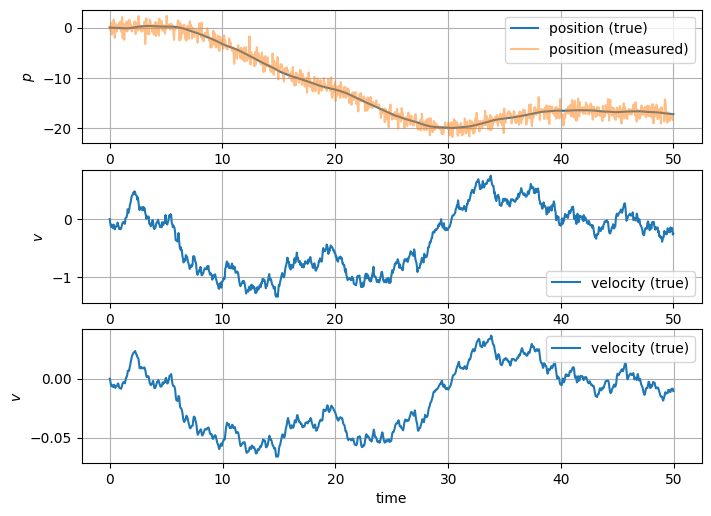

In [2]:
for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])


for t in range(N-1):
    #displacement 추가 
    #현재 변위 = 현재 위치 - 방금 전 위치
    dx[:,t+1] = x[0,t+1] - x[0,t]
    

x_true = x.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(3,1,1)
plt.plot(ts,x[0,:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(3,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
#displacement는 velocity와 모양이 같다. (속도에 증분을 곱한 것 이므로)
plt.subplot(3,1,3)
plt.plot(ts[:-1],dx[0,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

10 Layer model

====================시작===================

====================모델 생성===================
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 30        
__________________________________

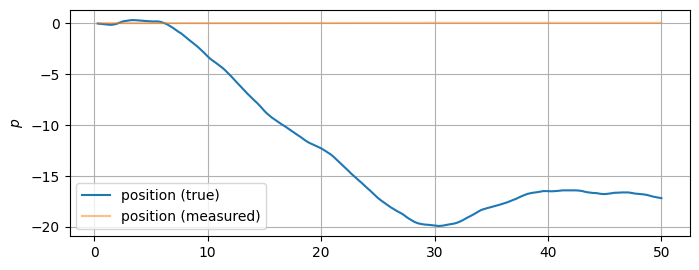

In [3]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 20
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



====================시작===================

====================모델 생성===================
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 30        
________________________________

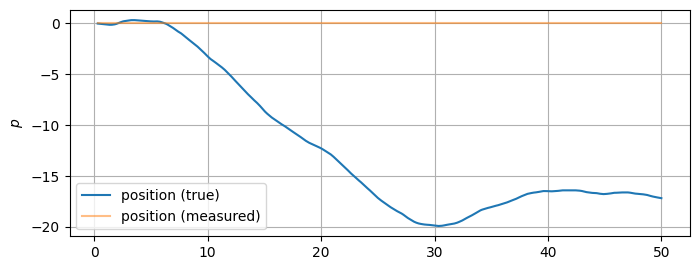

In [4]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(DS, activation='relu'),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



10 layer는 과적합이 발생하는 듯

2 layer, activation = none으로 실행

DS, ND = 5, 50

====================시작===================

====================모델 생성===================
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [1.1963753700256348]
              2 번째 cycle
loss = [0.768024206161499]
              3 번째 cycle
loss = [0.464922696352005]
              4 번째 cycle
loss = [0.2598176598548889]
              5 번째 cycle
loss = [0.12874461710453033]
              6 번째 cycle
loss = [0.051878366619348526]
              7 번째 cycle
loss = [0.013273961842060089]
              8

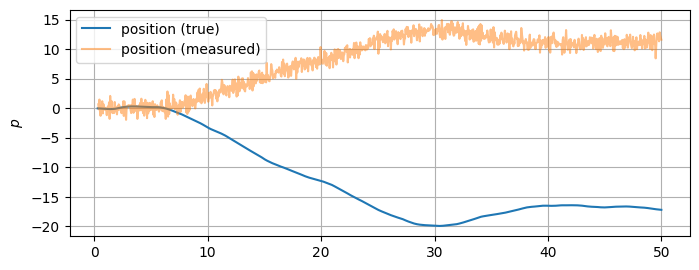

In [5]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 5, 100

====================시작===================

====================모델 생성===================
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [1.6084308624267578]
              2 번째 cycle
loss = [0.9462664723396301]
              3 번째 cycle
loss = [0.5369079113006592]
              4 번째 cycle
loss = [0.2862873375415802]
              5 번째 cycle
loss = [0.13859930634498596]
              6 번째 cycle
loss = [0.05820649117231369]
              7 번째 cycle
loss = [0.019783593714237213]
              

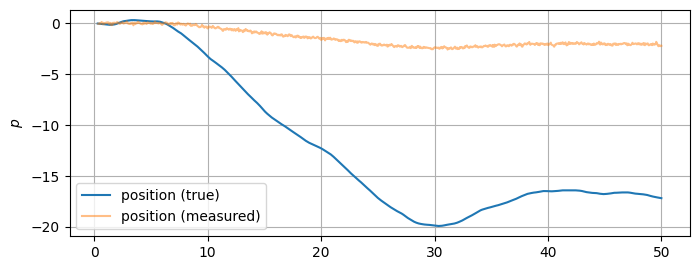

In [6]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



DS, ND = 5, 200

====================시작===================

====================모델 생성===================
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.42096295952796936]
              2 번째 cycle
loss = [0.10900465399026871]
              3 번째 cycle
loss = [0.02266698330640793]
              4 번째 cycle
loss = [0.0041619036346673965]
              5 번째 cycle
loss = [0.00041269449866376817]

====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.

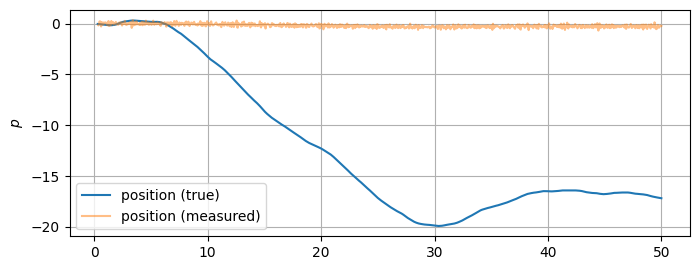

In [8]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 200
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 5
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 5 , 500

====================시작===================

====================모델 생성===================
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.405087947845459]
              2 번째 cycle
loss = [0.2366081327199936]

====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent

====================위치 출력===================


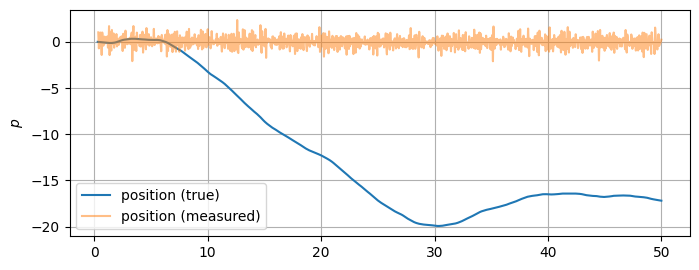

In [9]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 500
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 2
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



layer를 추가하면?

====================시작===================

====================모델 생성===================
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.003336386289447546]
              2 번째 cycle
loss = [0.007407877128571272]

====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 perce

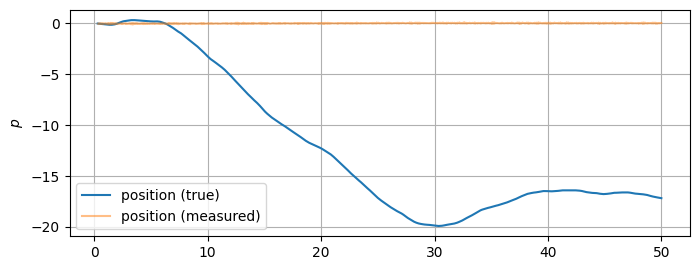

In [10]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 500
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 2
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



cycle을 줄이고 epoch를 늘린다면? => 학습시 안정성

====================시작===================

====================모델 생성===================
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.03336974233388901, 0.03220885246992111, 0.030908336862921715, 0.02949872612953186, 0.028008075430989265, 0.026462063193321228, 0.024883773177862167, 0.023293673992156982, 0.021709663793444633, 0.020147280767560005]

====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
7

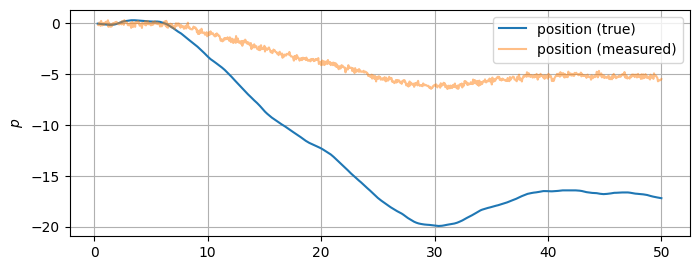

In [14]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 1
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 10, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



DS, ND = 10 ,50

====================시작===================

====================모델 생성===================
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.07455754280090332]
              2 번째 cycle
loss = [0.016368670389056206]
              3 번째 cycle
loss = [0.0001815416180761531]
              4 번째 cycle
loss = [0.005394648294895887]
              5 번째 cycle
loss = [0.01869414746761322]
              6 번째 cycle
loss = [0.032439909875392914]
              7 번째 cycle
loss = [0.04287876561284065]
   

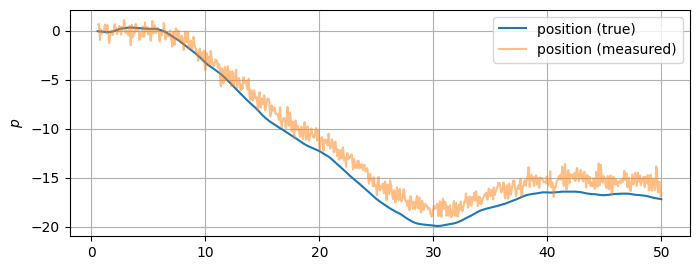

In [15]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



재현성이 있는지 확인

====================시작===================

====================모델 생성===================
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [8.431702613830566]
              2 번째 cycle
loss = [6.16684627532959]
              3 번째 cycle
loss = [4.530497074127197]
              4 번째 cycle
loss = [3.344461679458618]
              5 번째 cycle
loss = [2.4798426628112793]
              6 번째 cycle
loss = [1.8458452224731445]
              7 번째 cycle
loss = [1.378377914428711]
              8 번째 cy

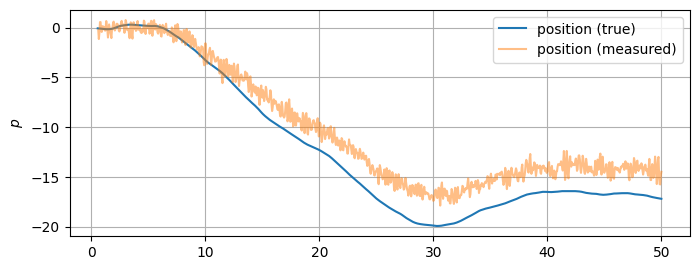

In [17]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



재현성이 있는듯, Cycle을 늘리면 정확도가 향상되는지 확인

====================시작===================

====================모델 생성===================
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.3558027744293213]
              2 번째 cycle
loss = [0.3709423840045929]
              3 번째 cycle
loss = [0.3645699620246887]
              4 번째 cycle
loss = [0.34158194065093994]
              5 번째 cycle
loss = [0.3070948123931885]
              6 번째 cycle
loss = [0.265910804271698]
              7 번째 cycle
loss = [0.22221416234970093]
              

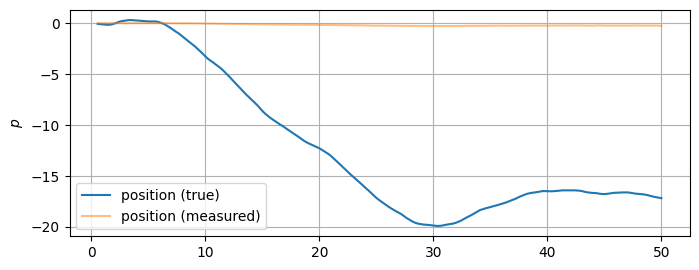

In [18]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 50
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



학습량을 너무 높이는건 과적합의 위험이 있는듯 / 25로 타협

====================시작===================

====================모델 생성===================
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [1.15109121799469]
              2 번째 cycle
loss = [0.6427925825119019]
              3 번째 cycle
loss = [0.340793639421463]
              4 번째 cycle
loss = [0.16874001920223236]
              5 번째 cycle
loss = [0.07600087672472]
              6 번째 cycle
loss = [0.029824327677488327]
              7 번째 cycle
loss = [0.009364361874759197]
              8

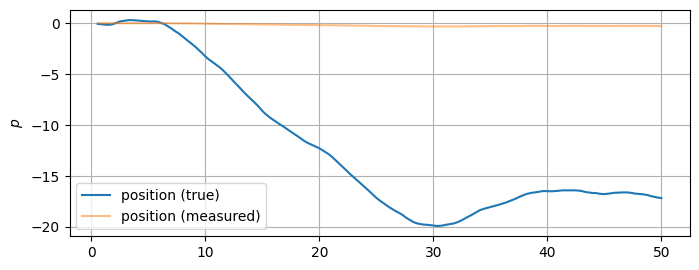

In [20]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 25
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



학습량을 높이는건 의미 없는듯

layer를 한 층 추가한다면

====================시작===================

====================모델 생성===================
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_54 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [4.674756050109863]
              2 번째 cycle
loss = [3.378079891204834]
              3 번째 cycle
loss = [2.3838789463043213]
              4 번째 cycle
loss = [1.620609998703003]
              5 번째 cycle
loss = [1.0538698434

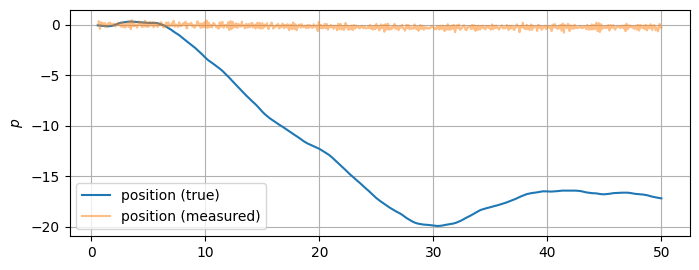

In [21]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



과적합 발생, dropout으로 generalize

====================시작===================

====================모델 생성===================
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________

====================학습==========

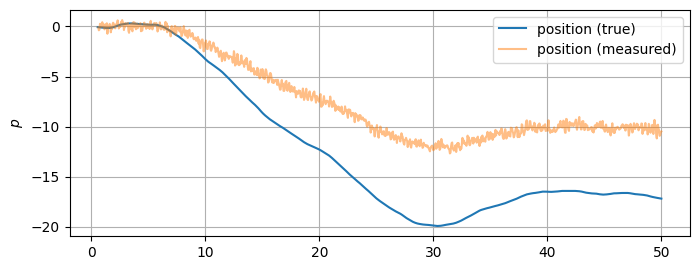

In [23]:

  #데이터 입력
print("====================시작===================")
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)])
  
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



====================시작===================

====================모델 생성===================
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_10 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_12 (Dropout)         (None, 10)                0         
_______________________________

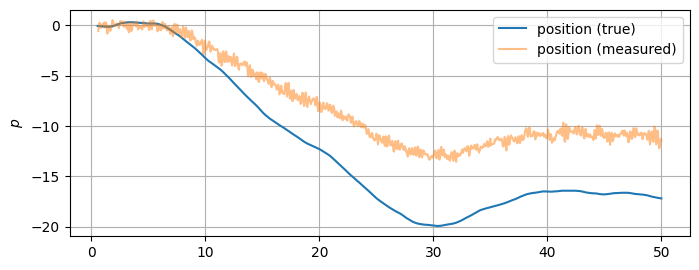

In [26]:

  #데이터 입력
print("====================시작===================")
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)])
  
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 20
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



필터링 효과가 있는듯, Cycle을 늘려봄

====================시작===================

====================모델 생성===================
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_15 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_16 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_17 (Dropout)         (None, 10)                0         
_______________________________

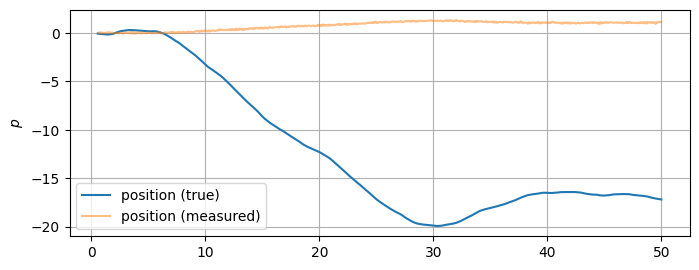

In [28]:

  #데이터 입력
print("====================시작===================")
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)])
  
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 50
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



epoch를 늘려봄

====================시작===================

====================모델 생성===================
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_18 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_19 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_20 (Dropout)         (None, 10)                0         
_______________________________

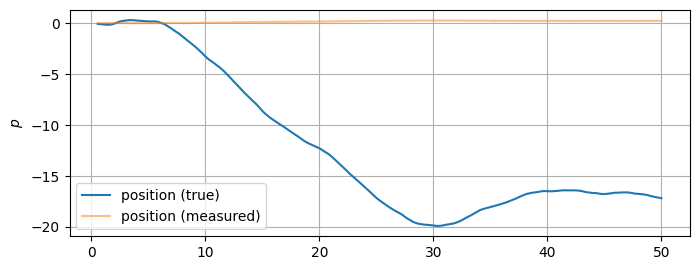

In [29]:

  #데이터 입력
print("====================시작===================")
DS ,ND = 10, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)])
  
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 10, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



학습량이 많아 과적합된듯

10, 50 은 이전 실험에서도 의미있는 결과를 냈던 적이 있음


====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0 percent
70.0 percent
80.0 percent
90.0 percent

====================위치 출력===================


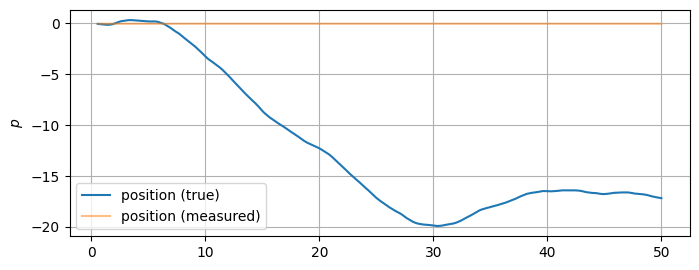

In [31]:
'''
  #데이터 입력
print("====================시작===================")
DS ,ND = 10, 500
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)])
  
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 50
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 10, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])
'''
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



DS, ND = 10, 100

====================시작===================

====================모델 생성===================
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.0776238888502121]
              2 번째 cycle
loss = [0.0846317857503891]
              3 번째 cycle
loss = [0.07738633453845978]
              4 번째 cycle
loss = [0.06363382935523987]
              5 번째 cycle
loss = [0.04833225533366203]
              6 번째 cycle
loss = [0.034295935183763504]
              7 번째 cycle
loss = [0.02283663861453533]
         

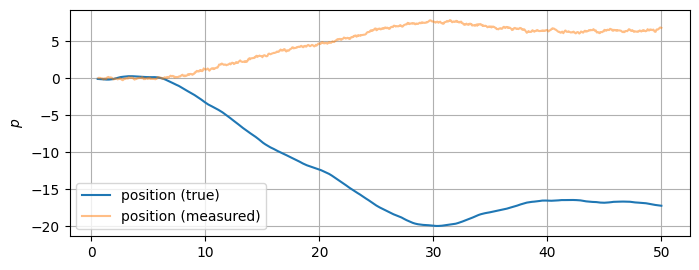

In [19]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



====================시작===================

====================모델 생성===================
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_13 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_14 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________

====================학습==========

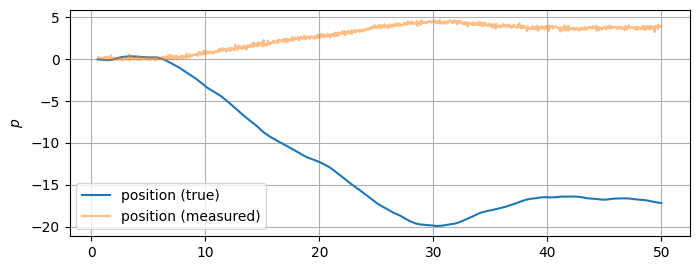

In [27]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10, 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])

for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(DS, input_dim=DS),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)])
  
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])
    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND 100은 적합하지 않은 듯